In [22]:
!pip install tweepy
!pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 MB 5.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 8.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [1]:
import tweepy
import os.path as path
import numpy as np
import nltk.tokenize as tk
import math
import scipy.stats as stats
import pandas as pd
import huggingface_hub
from scipy.stats import pearsonr
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
import torch
from transformers import BertModel
import sklearn.cluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

In [2]:
def get_all_examples():
    """Load all examples from a CSV file using pandas and return those that contain text.

    Returns:
        A list of tweets (or data) that contain text.
    """
    save_file = './twitter_emoji.csv'
    
    if path.exists(save_file):
        df = pd.read_csv(save_file, lineterminator = '\n')
        ids_to_examples = df[df['Text'].notna()].to_dict(orient='records')  # Convert to list of dicts
    else:
        print('Could not find tweets, so returning an empty list!')
        ids_to_examples = []

    return ids_to_examples


def get_emojis_in_tweet(tweet, emojis, tokenizer):
    """Get a list of all the emojis in a tweet based on the sets provided

    Args:
        tweet: Tweet
        tokenizer: NLTK tokenizer

    Returns:
        Emojis in a tweet
    """
    tokens = tokenizer.tokenize(tweet['Text'])
    ems = set()
    for token in tokens:
        if token in emojis:
            ems.add(token)
    return ems


def get_tweets_with_emoji(tweets, emojis):
    """Get all tweets with emoji in the sets

    Args:
        tweets: List of Tweets

    Returns:
        All tweets containing emoji

    """
    tokenizer = tk.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    ems = list()
    for tweet in tweets:
        if get_emojis_in_tweet(tweet, emojis, tokenizer):
            ems.append(tweet)
    return ems


In [3]:
tweets = get_all_examples()
tweetsWithPointRight = get_tweets_with_emoji(tweets, ["👉"])
lines = []
for tweet in tweetsWithPointRight:
    lines.append(tweet["Text"])

lines

['🧡@KeplerHomes AirdropBox event for #Arbitrum ecological users is here. A total of 550,000 addresses are eligible for #airdrop, and 5 types of AirDropbox with different scarcity can be issued.\n\n💙Invitation code: 52DC39\n🏆Airdrop Portal:👉 https://t.co/fudohu97uV',
 'Remember, success in online business is a marathon, not a sprint. Keep at it, stay focused, and success will come." #patience #onlinebusiness #success\nFor more tips and Strategies, follow me 👉 @coach_lawrence1 https://t.co/IvtL9Om86J',
 '@occupied_9 @Rhiannon_clare_ @FightHaven Thanks for the update the sh*t country the sh*t police 👉💩😡',
 "📢 It's confirmed. Whitelist for Shardeum Airdrop is here.\n\nYou can now join our whitelist, there are over 30000 spots. (First come First Served)\n👉 https://t.co/aHulc12YTO\n\nThe amount of tokens you receive during the Airdrop will depend on your portfolio and testnet status. https://t.co/DiukBFV93K",
 '7/ What to do next?\n\n-Using these bridges:\n👉https://t.co/NwvBsrpz7F\n(Polygon-

In [52]:
checkpoint = 'bert-base-uncased'

model = AutoModelForMaskedLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.add_tokens(["👉"])
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30523, 768, padding_idx=0)

In [53]:
# and adapting the other function
def combined_vector_for(targetword, text, bert_input, bert_output,
                        layer = -1, word_occurrence = 0):
    """
    calculate a word vector
    based on the mean of the WordPiece vectors in the given layer.
    targetword is a word appearing in text.
    bert_input is the whole dictionary returned by the tokenizer.
    bert_output is the last-layer output obtained
    on this text.
    """
    tokenized_text = [w for w, n in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]

    # where in the tokenized text (split into words but not split into word pieces)
    # do we find the target word?
    target_word_indices = [i for i, x in enumerate(tokenized_text) if x == targetword]

    # sanity check
    if len(target_word_indices) < word_occurrence + 1:
        # no occurrences found, or not enough to match the required one
        return None

    # if multiple occurrences of the target word, we use this one
    usethis_targetword_index = target_word_indices[ word_occurrence]

    # use word_to_tokens to determine the word piece span of the target word
    word_start, word_end = bert_input.word_to_tokens( usethis_targetword_index )

    # extract the embeddings from the right layer, and the target vectors from that layer
    embeddings= bert_output["hidden_states"][layer]
    # print(embeddings.shape)
    target_vectors = embeddings[0, word_start:word_end, :]

    # if we have multiple word pieces for ti'his word, average over them
    avg_target_vector = target_vectors.mean(dim = 0)

    return avg_target_vector.detach().numpy()



In [64]:
embeddings = []
# checkpoint = 'bert-base-uncased'
for line in lines:

    text = line

    bert_inputs = tokenizer(text, padding=True, truncation=True,  return_tensors="pt")

    bert_output = model(bert_inputs["input_ids"], output_hidden_states = True)

    charge_output = combined_vector_for("👉", text, bert_inputs, bert_output, layer = 7, word_occurrence = 0)
    embeddings.append(charge_output)

print(len(embeddings))
# print(embeddings)


SyntaxError: invalid syntax (189669765.py, line 12)

In [66]:
embeddings = [x for x in embeddings if x is not None]

In [68]:
kmeans = sklearn.cluster.KMeans(n_clusters=5, random_state=2048).fit(embeddings)
#random_state makes clustering deterministic - it's a seed value

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [70]:
cluster_list = kmeans.predict(embeddings)
print(list(cluster_list))

[0, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 4, 1, 3, 0, 2, 2, 4, 3, 1, 3, 0, 0, 1, 0, 3, 0, 0, 1, 3, 4, 2, 2, 4, 0, 0, 1, 0, 3, 0, 1, 1, 1, 0, 3, 1, 1, 2, 1, 0, 3, 4, 0, 0, 3, 0, 3, 0, 3, 4, 4, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 2, 3, 1, 0, 3, 3, 0, 2, 0, 0, 2, 4, 2, 2, 2, 0, 0, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 1, 0, 0, 0, 3, 3, 3, 0, 3, 2, 1, 0, 1, 0, 2, 3, 3, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 0, 2, 0, 0, 3, 0, 1, 0, 1, 1, 2, 2, 1, 0, 3, 3, 3, 0, 0, 0, 0, 0, 4, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 3, 1, 0, 3, 1, 0, 0, 0, 2, 2, 3, 1, 3, 3, 3, 3, 0, 0, 1, 2, 0, 0, 3, 2, 0, 1, 0, 2, 0, 1, 3, 0, 2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2, 3, 2, 3, 2, 2, 3, 1, 2, 1, 2, 2, 3, 2, 2, 3, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 1, 3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 4, 1, 0, 3, 2, 2, 0, 0, 3, 3, 2, 0, 0, 0, 1, 1, 0, 4, 0, 1, 0, 2, 0, 3, 2, 0, 1, 2, 1, 1, 0, 2, 2, 2, 2, 1, 4, 1, 2, 2, 1, 2, 3, 3, 0, 4, 3, 0, 0, 3, 0, 4, 0, 2, 0, 2, 4, 3, 0, 2, 0, 1, 4, 0, 1, 3, 4, 0, 2, 

In [72]:
cluster_dict = {0:[],1:[],2:[],3:[],4:[]}
for i in range(len(cluster_list)):
  cluster_dict[cluster_list[i]].append(i)

In [76]:
outs = 3
random.seed(50)

for cluster in cluster_dict.keys():
  sents = random.sample(cluster_dict[cluster],outs)
  for sent in sents:
    print(lines[sent])

  print()

Check out this product 😍 WS 8  Pro Ultra Black + free Bubble Strap 😍 
by Smart Watch South Africa  starting at R 999.00. 
Shop now 👉👉 https://t.co/hnXWgZRTZ4 https://t.co/o2AY3EI7Sn
The act of creating affirmations can be a powerful practice for anyone looking to make positive changes in their life, and it doesn't have to be difficult, either.

Read more 👉 https://t.co/bCyNkSWr60

#LoveUMagazine #PositiveAffirmations #BlogPost #CreateLastingChange https://t.co/U1meRqt9qn
👉Limited creativity🫤 and innovation 🔮

If you ask an AI for information, it will provide information to you. 
If you ask a human, they may invite you to share your understanding 😇of the problem and offer guidance and their experience in discovering a solution.

Hey GUYS!

It's LIVE NOW - $WIFI token is LIVE now @gate_io! 🚀

📈Start Trading $WIFI  before more find out! Keep an eye on @wifimapapp, looks like it could be a new Web3 unicorn! 

Trade Now 👉 https://t.co/TIFj3oYji5

Telegram: https://t.co/GiALzSrYoL

#listing 

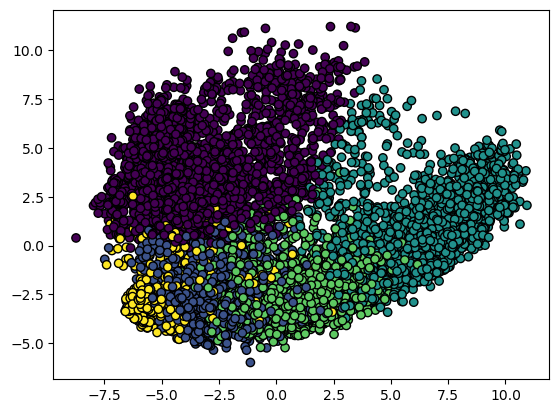

In [78]:
twodim = PCA().fit_transform(embeddings)[:,:2]

# set up the canvas
fig, ax =  plt.subplots()

# add a scatter plot of the two-D embeddings
scatter = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=cluster_list)

# and show the canvas
plt.show()